<a href="https://colab.research.google.com/github/vgandhi13/SNN-1-Shot-Recognition/blob/main/SNN_1_Shot_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
print("version:", sys.version)

version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


#Setup

###-Installation

In [ ]:
!pip install tensorflow==2.8.0 tensorflow-gpu==2.8.0 opencv-python matplotlib #need a different version of python, like 3.6/ 3.7/ 3.8

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 44.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-

###-Import Dependencies

In [ ]:
import cv2 #opencv
import os #abstracts os from python code, used to work with directories and filepaths
import random
import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten #for embedding layers
import tensorflow as tf



###-GPU limit

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU') #getting all existence gpu on current machine
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True) #looping through gpu and setting growth

### Creating Directories for images


In [ ]:
positive_path = os.path.join('data', 'positive')
negative_path = os.path.join('data', 'negative')
anchor_path = os.path.join('data', 'anchor')
os.makedirs(positive_path)
os.makedirs(negative_path)
os.makedirs(anchor_path)

### Positive and Anchor Images collection

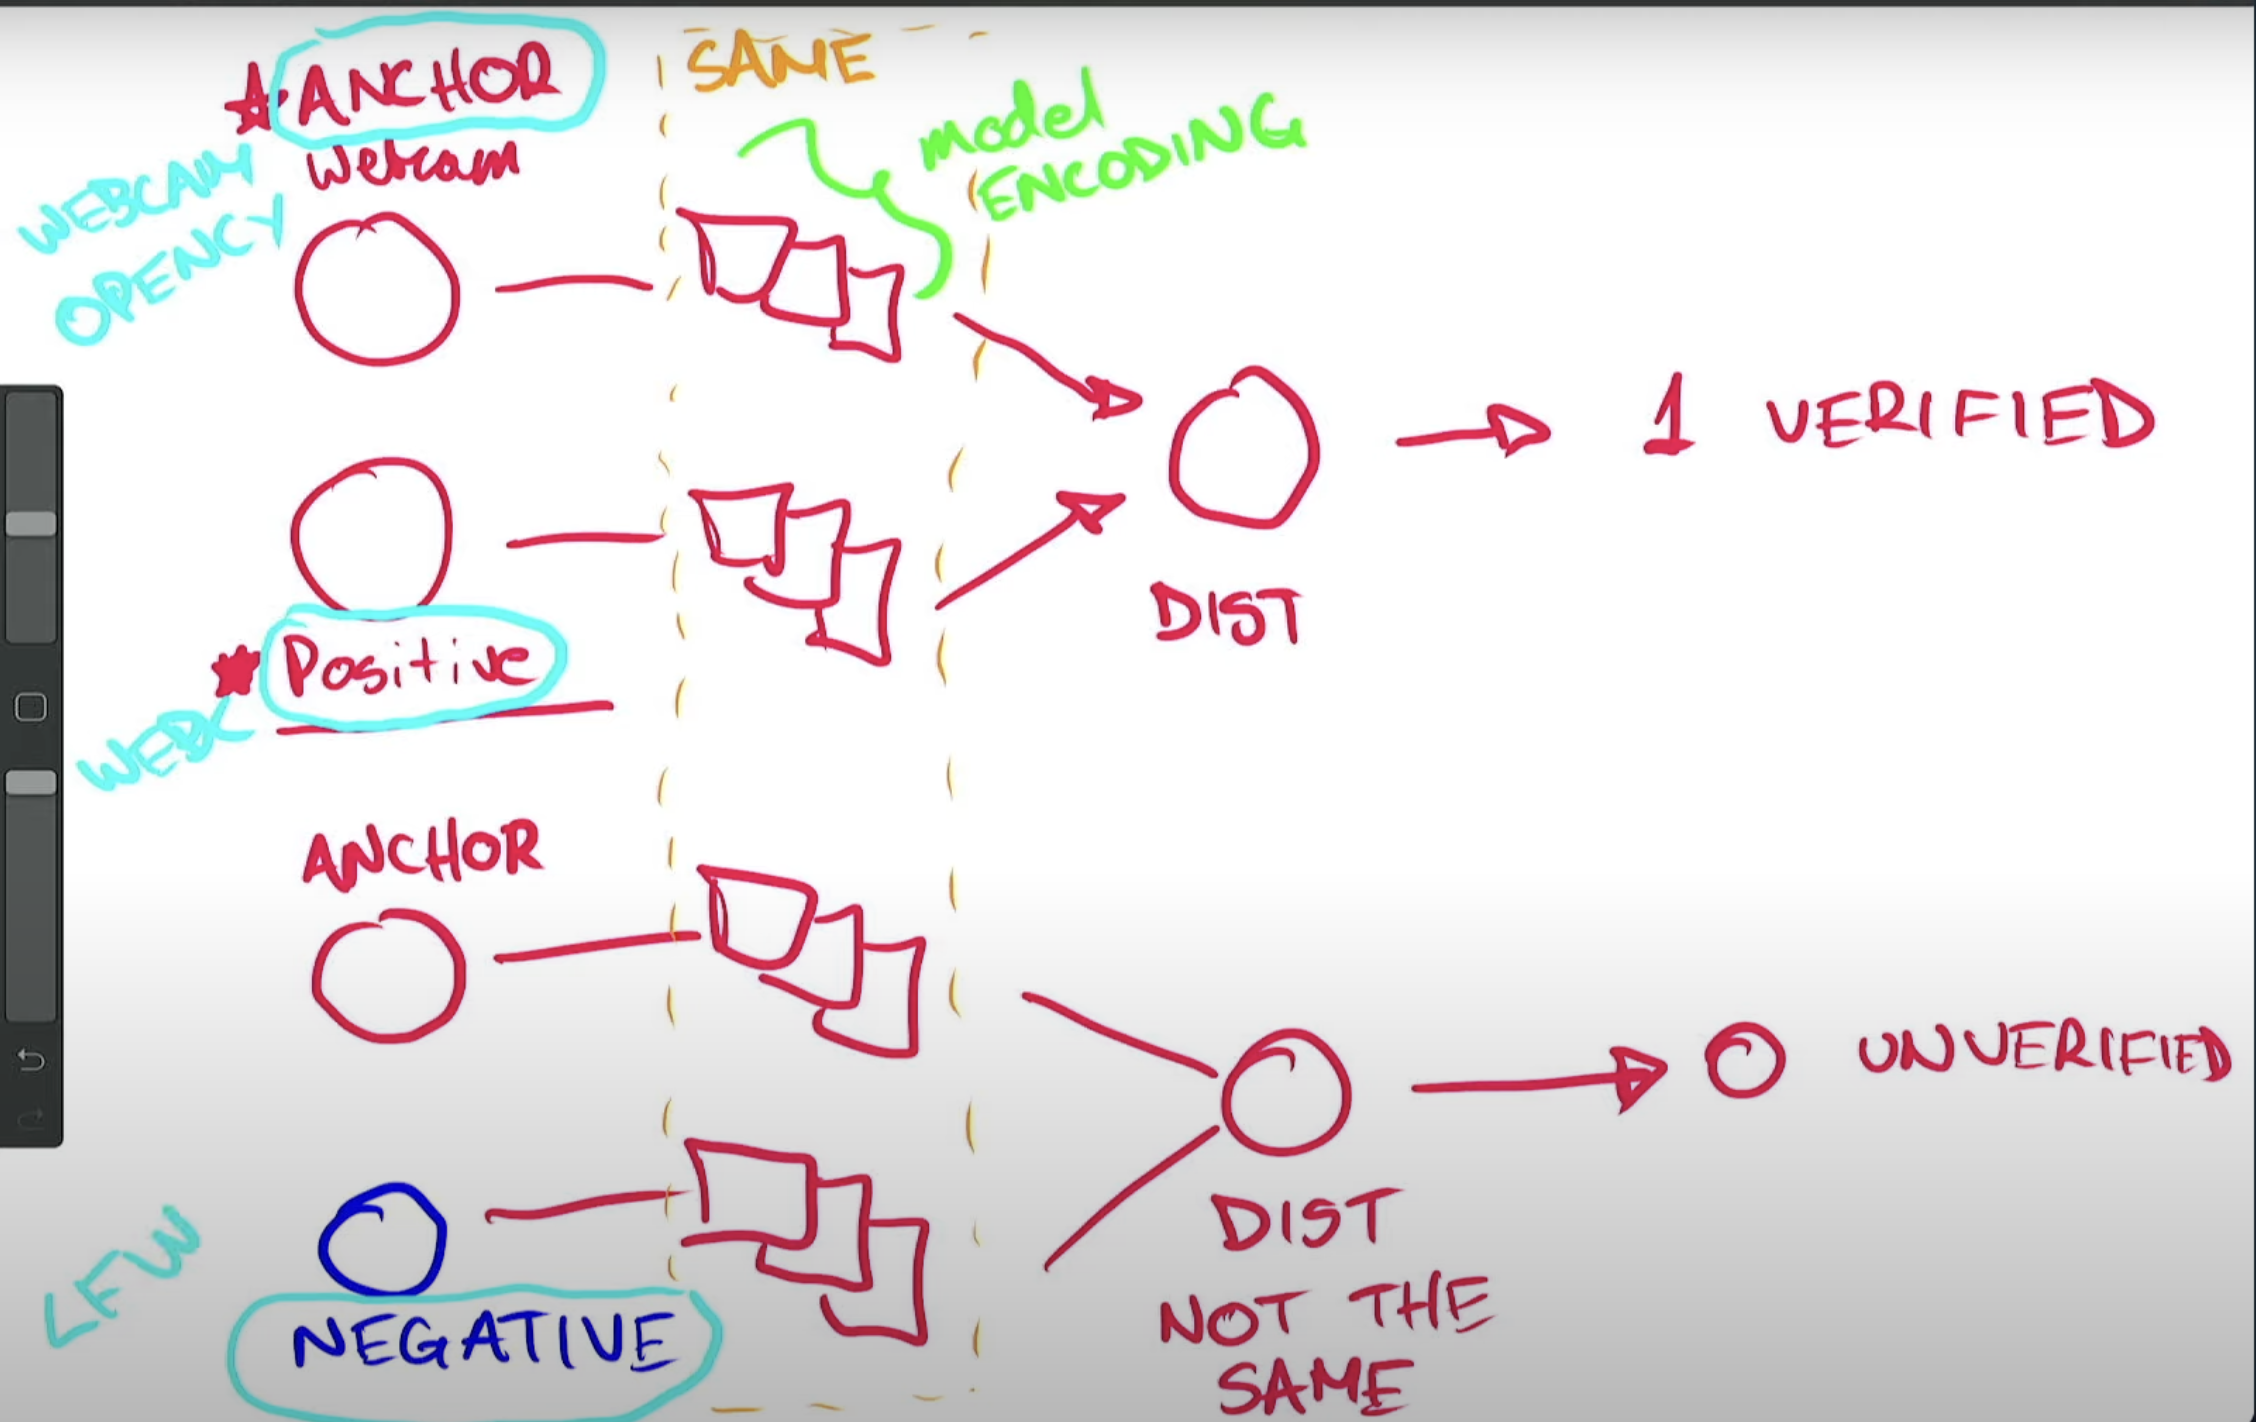

#### Getting sample images for negatives below

In [ ]:
#!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz

#####Unzipping the images


In [ ]:
#!tar -xzvf lfw.tgz

####Putting the images into the appropriate folders below

In [ ]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(negative_path, file)
        os.replace(EX_PATH, NEW_PATH)

####Collecting positive and anchor class

In [ ]:
import uuid #generates unique image names
os.path.join(anchor_path, '{}.jpg'.format(uuid.uuid1())) #gives a new id
# if you run this snippet, it'll give a unique name every time. we are using this to assign names to anchor and positive images.

'data/anchor/ad93279c-b54b-11ee-8f13-0242ac1c000c.jpg'

In [ ]:
#for i in range(10):  # Try the first 10 indices
    #cap = cv2.VideoCapture(i)
    #if cap.isOpened():
        #print(f"Camera index {i} is working.")
        #break

#### We have two streams when it comes to building our models, we have anchor image that we pass to it, we also have the positive image or the negative image. We are effectively going to be verifying whether our anchor images matches the positive image or the negative image. Should output 1 if matches the positive, should output 0 if matches the negative

#### Press A to get anchor images, press P to get positive images

In [ ]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    #show image back to screen
    cv2.imshow('Image Collection', frame)

    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]

    # Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path
        #we are storing anchor images in anchor path.
        imgname = os.path.join(anchor_path, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)

    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path
        imgname = os.path.join(positive_path, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)

    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()


In [ ]:
plt.imshow(frame[120:120+250,200:200+250,:])

NameError: name 'plt' is not defined

# Preprocessing the images


####We will use tensorflow data loader to create create data pipeline which will make building deep learning models way easier. First we will upload all three folders from their respective directories, we are going to create a preprocessing pipeline and then we will associate our positive and negative classes

In [ ]:
#Getting image directories

anchor = tf.data.Dataset.list_files(anchor_path+'\*.jpg').take(300) #creates a pipeline for all the file within this directory, essentially grab everything inside ancor_path that has the extension jpg. 300 says take only 300 images
positive = tf.data.Dataset.list_files(positive_path+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(negative_path+'\*.jpg').take(300)

NameError: name 'tf' is not defined

In [ ]:
#test

dir_test = anchor.as_numpy_iterator()

NameError: name 'anchor' is not defined

In [ ]:
dir_test.next() #file keeps on changing moving on to next, whenever this block is ran

#when we go and batch our data together, the way our model works is that we are going to train a batch at a time. We will grab one batch out of this dataset
# we will then go ahead and train this batch, do forward pass, calculate loss, calculate gradient, etc. this iterator/data pipeline allows us to do that

### Preprocessing - Scale and Resize

In [ ]:
#this function loads a image from the directory, resize it and perform some scaling. Convert all images from 0-255 to 0-1. This helps the neural network optimize a lot easier and makes the gradient descent a lot easier and helps us achieve a better performing model.

def preprocess(file_path):
   # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    # we do this because the input image in the paper is 105 X 105.
    img = tf.image.resize(img, (105,105))
    # Scale image to be between 0 and 1
    # takes every single pixel value in img which is traditionally betn 0 & 255 and divides it to be betn 0 and 1
    img = img / 255.0

    # Return image
    return img

####this above function above essentially loads our image from file path, decode the jpeg, resize the image, perform scaling by div by 255 and return the img

In [ ]:
img = preprocess(dir_test.next()) #returns a numpy equivalent
plt.imshow(img)

In [ ]:
dataset.map(preprocess) #will allow us to apply preprocess function to every single image in ancor, positive, and negative classes

### Create a labelled dataset

#### We are going to create a positive and a negative example. When we go and validate, we are actually going to pass through an anchor image and a positive image and this should ideally output 1 and we can be verified. We should also pass through an anchor image and a negative image and that should output 0.

In [ ]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0


In [ ]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))))) #essentially if positive and anchor of same person, label assigned 1 here
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor))))) #essentially if positive and anchor of same person, label assigned 0 here
data = positives.concatenate(negatives)

In [ ]:
samples = data.as_numpy_iterator()

In [ ]:
exampple = samples.next()

In [ ]:
exampple
##essential in the exampple dataset, (anchor, positive, 1) and (anchor, negative, 0)

##Build Train and Test Partition.

In [ ]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [ ]:
res = preprocess_twin(*exampple)

In [ ]:
plt.imshow(res[1])

In [ ]:
res[2]

In [ ]:
# Build dataloader pipeline
data = data.map(preprocess_twin) #apply preprocess on all tuples
data = data.cache()  #cachng our images
data = data.shuffle(buffer_size = 1024) # muddles images so that it is not just positive image tuples and then negative but instead shuffled.

In [ ]:
data # each tuple in data consists of anchor img, positive/negative img and label (if positive then 1, else 0)

so this is how neural network is going to work and this is effectively one shot classification. we can pass through an anchor image(input) and then we can pass a separate image which we want to validate against, and it'll tell us whether or not it is the same person. So suppose if we want to do verification on mutliple images or recognition on multiple people, we will just include more positive example

In [ ]:
# Training partition
train_data = data.take(round(len(data)*.7)) # grabs a certain percentage of our dataset, round(len(data)*.7) this just comes up with how many images
train_data = train_data.batch(16) #we pass data in a batch of 16 of those grabbed
train_data = train_data.prefetch(8) #this effectively starts preprocessing next set of data

In [ ]:
# Testing partition
test_data = data.skip(round(len(data)*.7)) #here we skip first 420 observations so that we dont pick up our trained sample
test_data = test_data.take(round(len(data)*.3)) # and then we take the last 30 % , will grab last 180 images
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

Summary of what we did,  we first grabbed all our image directories using tf, we then went ahead and preprocessed them, we unloaded, resized and scaled the images. we then created a labelled dataset, we created a positive sample, a negative sample, and concatenated them together. built up a data pipeline using preprocess function, and then created a training partition and a testing partition